In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1199_BNG_echoMonths', return_X_y=True)

In [5]:
X.shape

(17496, 9)

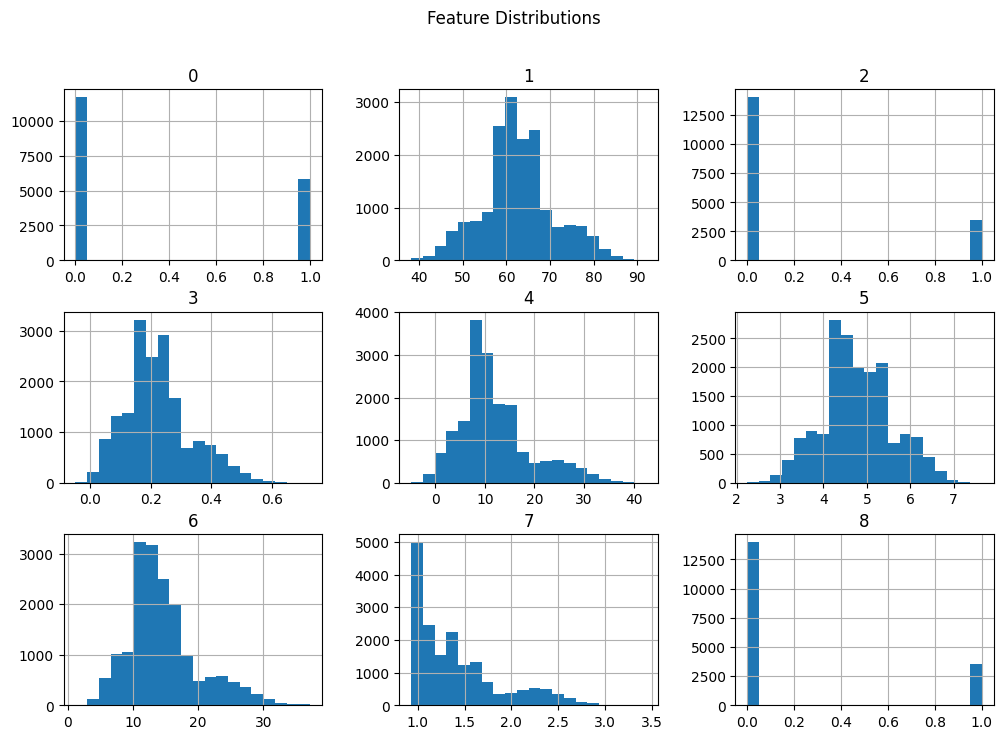

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

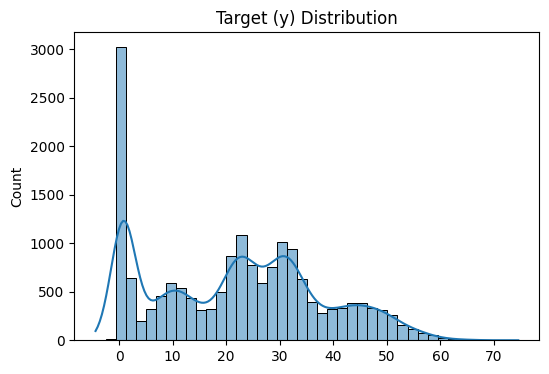

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

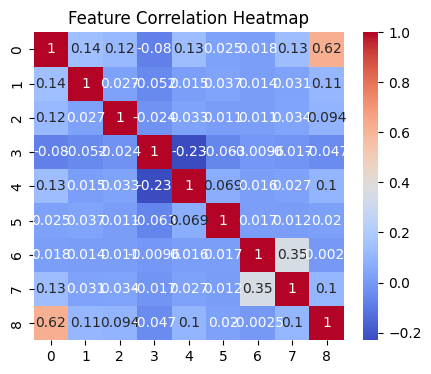

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.044062                 1.117711             1.260115   
1                  1.052978                 1.047965             1.109923   
2                  1.057881                 1.018817             1.537823   
3                  1.018467                 1.039862             1.201808   
4                  1.089855                 1.056341             1.214428   
mean               1.052649                 1.056139             1.264819   
std                0.025758                 0.037134             0.162061   

      DefaultBART_Rhat_RMSE  
0                  1.188103  
1                  1.238458  
2                  1.368306  
3                  1.592096  
4                  1.268651  
mean               1.331123  
std                0.160027  


In [10]:
rhat_df.to_csv("results/real6_echoMonths_rhat.csv", index=False)

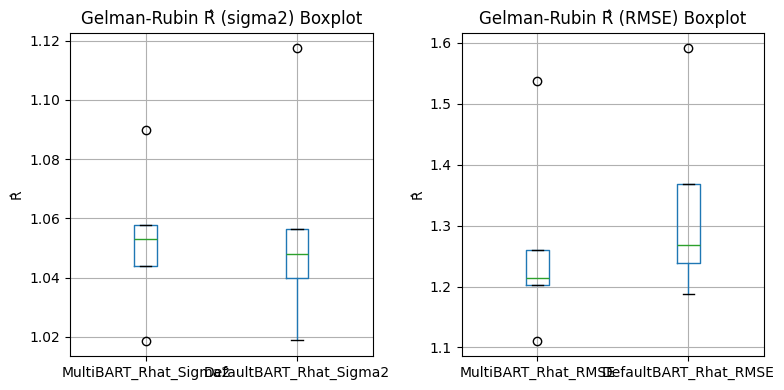

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-10-28 19:04:59,498:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-28 19:05:05,747:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-28 19:05:16,093:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
       bart_mtmh        bart         btz          rf         xgb
0     128.932166  130.072398  128.896604  132.644593  139.323217
1     131.012768  131.909921  132.698415  135.221860  142.761038
2     128.847824  129.943772  129.785147  134.094306  139.665325
3     130.138581  130.399375  130.865317  136.009708  142.592322
4     129.484577  130.578627  131.089642  134.661939  142.401405
5     132.399563  132.613602  133.905436  137.830949  144.409112
6     127.257585  129.209381  129.154683  130.075645  143.240277
7     133.160036  134.715332  135.338537  137.396965  146.489538
8     129.363540  131.302296  132.440433  134.223581  144.326072
9     127.538009  126.397797  126.890079  129.732321  139.346478
mean  129.813465  130.714250  131.106429  134.189187  142.455479
std     1.919532    2.196238    2.545881    2.735311    2.394027



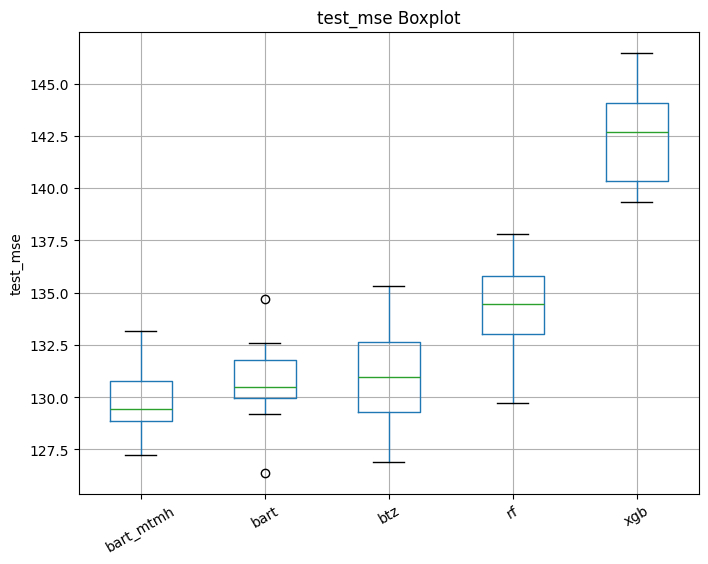

train_mse:
       bart_mtmh        bart         btz         rf        xgb
0     121.278528  123.604706  125.820256  18.837764  60.015500
1     120.514072  122.713965  126.047819  18.643544  56.621137
2     121.919874  124.895783  125.360344  18.682658  60.429968
3     120.295099  123.412850  125.596901  18.630229  59.054943
4     121.509780  123.492477  126.416412  18.653725  59.621118
5     120.500673  122.894928  124.980261  18.613275  59.194286
6     122.306103  123.602634  126.255680  18.792801  60.125988
7     119.398239  121.873290  124.796215  18.492577  59.351145
8     121.031745  124.031267  126.338811  18.767559  57.660885
9     122.774946  123.571904  127.658214  18.807122  58.739761
mean  121.152906  123.409380  125.927091  18.692126  59.081473
std     1.019539    0.803658    0.826323   0.107524   1.171292



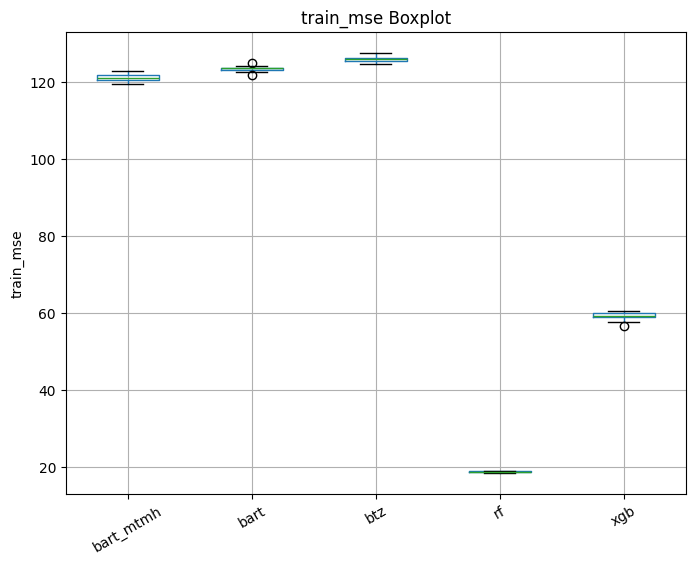

pi_length:
      bart_mtmh       bart        btz
0     44.062341  44.154570  44.802078
1     43.761454  44.038911  44.802711
2     44.052590  44.424994  44.669296
3     43.900723  44.146002  44.820107
4     43.952783  44.132811  44.743359
5     43.900980  44.093901  44.665253
6     44.140402  44.286289  44.814003
7     43.596674  43.917413  44.580017
8     43.973884  44.214360  44.835670
9     44.133757  44.122948  45.210793
mean  43.947559  44.153220  44.794331
std    0.169609   0.136985   0.169035



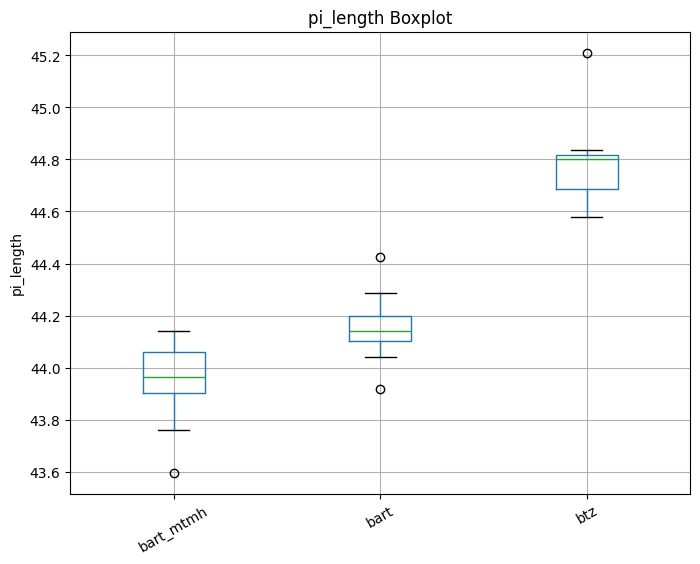

coverage:
      bart_mtmh      bart       btz
0      0.938272  0.936214  0.941244
1      0.936900  0.935757  0.941015
2      0.935985  0.940329  0.942387
3      0.937128  0.940329  0.939872
4      0.938043  0.939872  0.943759
5      0.938272  0.937586  0.937128
6      0.943073  0.942844  0.943759
7      0.933471  0.933928  0.941244
8      0.937586  0.935299  0.940558
9      0.941472  0.943759  0.949931
mean   0.938020  0.938592  0.942090
std    0.002680  0.003329  0.003360



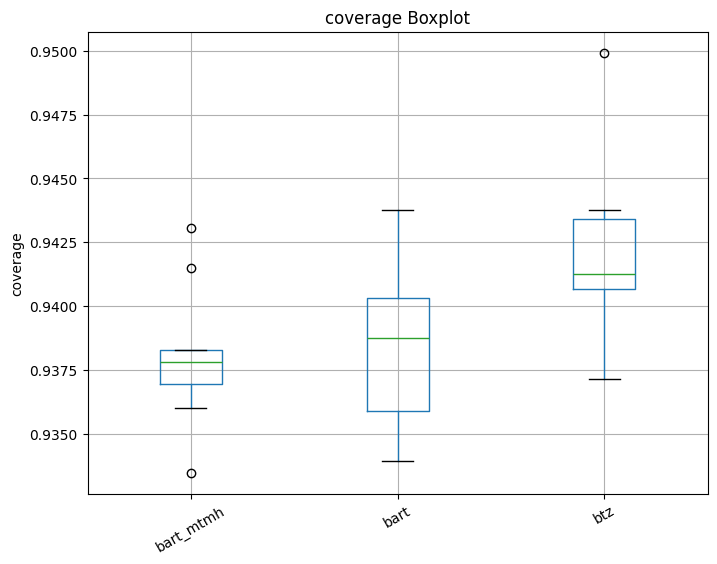

train_time:
       bart_mtmh       bart        btz         rf       xgb
0     502.925824  69.270700  74.704337  15.249936  0.284972
1     489.325145  72.532235  75.156982  15.494304  0.288955
2     501.450179  74.220304  77.895277  15.185221  0.185060
3     513.718768  73.834199  79.410170  13.290000  0.159542
4     480.682878  74.865279  75.273706  15.653706  0.340265
5     514.900179  69.859202  80.408305  15.007375  0.162432
6     482.959782  68.182212  75.015314  15.635293  0.334075
7     491.364473  69.054218  77.071419  18.354337  0.292106
8     496.332660  71.448728  79.796012  15.425569  0.289489
9     497.503048  73.005374  79.438013  12.573390  0.160854
mean  497.116294  71.627245  77.416954  15.186913  0.249775
std    11.592407   2.403645   2.256867   1.529995  0.074015



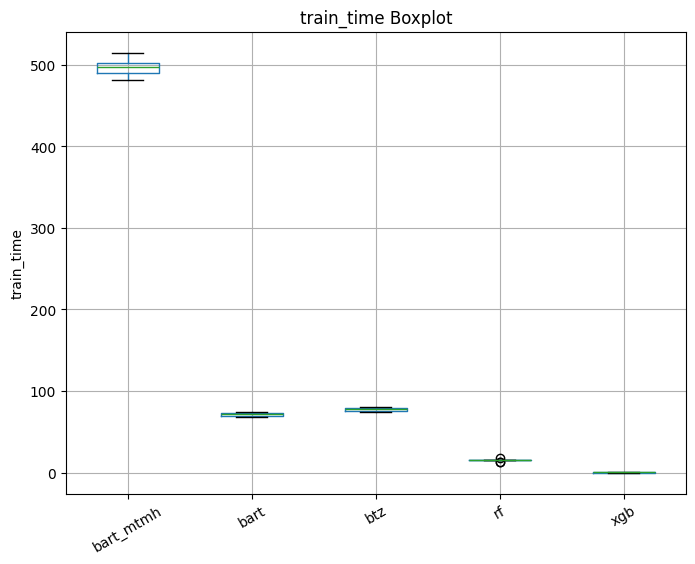

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real6_echoMonths_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real6_echoMonths_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1,5,10,50,100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real6_echoMonths_tries.csv", index=False)

In [ ]:
print(df)